# Single Track Jets

Motivation: It seemed like a lot of the performance loss that we were seeing with RNNIP was being driven by the *lowest* track multiplicity bin.

<img src="../figures/ip3d/roc_lrej_hits_rnn_nTrks.pdf" width="400">

By training a simple feed-forward network, we wanted to see if we could *gain* in performance by including some extra physics variables into the net.

But first off, we weren't even sure whether just training on single track jets could increase our performance or not, b/c maybe it was learning how to train the neurons using all of the tracks in the jet, not just the first one!

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from keras.models import Model, load_model
from keras.layers import Masking, Input, Dense, Dropout, LSTM, Lambda
from keras.layers import concatenate, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## Step 1: Load in a dataset and select jets that only have *one* track

In [2]:
# Debugging: Ok, so I think I can debug here + then implement in 
# root_to_np.py
filepath = "../data/mc16d"
data_tag = "3m_15trks_sd0_rev"

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(filepath,data_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(filepath,data_tag))


In [3]:
jet_df.head()

LabDr_HadF    pt_orig  eta_orig  phi_orig             m  ip3d_llr  \
0         4.0  82.521891 -1.647832 -1.115594   7076.710449  8.030893   
1         4.0  72.872375  1.698972  2.003417   8230.029297  3.700817   
2         5.0  34.415184  2.089628 -0.551500   6249.994629  5.713408   
3        15.0  28.808963  1.997881  3.136153   4981.111328 -1.069982   
4         0.0  53.356875 -2.145085  2.970182  10792.095703  1.418369   

    ip3d_pb   ip3d_pc   ip3d_pu  ip3d_ntrk    ...      aliveAfterOR  \
0  0.070772  0.002910  0.000023        4.0    ...               1.0   
1  0.028174  0.010117  0.000696        4.0    ...               1.0   
2  0.046954  0.003810  0.000155        4.0    ...               1.0   
3  0.056802  0.125082  0.165595        2.0    ...               1.0   
4  0.000938  0.002009  0.000227        6.0    ...               1.0   

         llr       JVT         pt       eta  rnnip_pu  rnnip_pc  rnnip_pb  \
0   6.596817  0.998500  85.362094 -1.646813  0.017968  0.080970  0.895366   
1   2.755359  0.995474  65.487230  1.697786  0.128092  0.270342  0.586582   
2   1.964071  0.997876  35.314129  2.089185  0.002254  0.018693  0.978173   
3 -99.000000  0.998573  25.361543  1.997358  0.632889  0.117815  0.063850   
4 -99.000000  0.987650  55.109125 -2.144747  0.669229  0.171371  0.156907   

   rnnip_ptau     bH_Lxy  
0    0.005695 -99.000000  
1    0.014983 -99.000000  
2    0.000880   6.741858  
3    0.185446 -99.000000  
4    0.002493 -99.000000  

[5 rows x 21 columns]

Access the jets with only one track.

In [43]:
dataFile = '../data/mc16d'
dataTag = "3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm"
f = h5py.File("{}/data_{}.hdf5".format(dataFile,dataTag),"r")

X_tr  = f['X_train'][:]
y_tr  = f['y_train'][:]
ix_tr = f['ix_train'][:]
w_tr = f['weights_train'][:]

X_te  = f['X_test'][:]
y_te  = f['y_test'][:]
ix_te = f['ix_test'][:]
w_te = f['weights_test'][:]

f.close()

# training set
oneTrk_tr = (jet_df.ip3d_ntrk == 1).values[ix_tr]

X_tr  = X_tr[oneTrk_tr,0,:]
y_tr  = y_tr[oneTrk_tr]
ix_tr = ix_tr[oneTrk_tr]
w_tr  = w_tr[oneTrk_tr]

# test set
oneTrk_te = (jet_df.ip3d_ntrk == 1).values[ix_te]

X_te  = X_te[oneTrk_te,0,:]
y_te  = y_te[oneTrk_te]
ix_te = ix_te[oneTrk_te]
w_te  = w_te[oneTrk_te]


In [5]:
_,nFeatures = X_tr.shape
N_CLASSES = 4

### Plan: Let's look at a simple model

For the PUNN project, an architecture with 25-10 hidden nodes worked pretty well, so I guess I could try it out here, although I perhaps could go even simpler?

In [6]:
from keras.models import Model, load_model
from keras.layers import Masking, Input, Dense, Dropout, LSTM, Lambda
from keras.layers import concatenate, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

In [7]:
trk_inputs = Input(shape=(nFeatures,),name="Trk_inputs")
#masked_input = Masking()(trk_inputs)

dense1 = Dense(25, activation='relu', name="Dense1")(trk_inputs)
dpt = Dropout(0.2, name="Dropout")(dense1)
dense2 = Dense(10, activation='relu', name="Dense2")(dpt)

out = Dense(N_CLASSES, activation="softmax",name="Jet_class")(dense2)

model = Model(inputs=trk_inputs, outputs=out)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 17)                0         
_________________________________________________________________
Dense1 (Dense)               (None, 25)                450       
_________________________________________________________________
Dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
Dense2 (Dense)               (None, 10)                260       
_________________________________________________________________
Jet_class (Dense)            (None, 4)                 44        
Total params: 754
Trainable params: 754
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [10]:
nEpochs = 100

history = model.fit(X_tr, to_categorical(y_tr,N_CLASSES),
                    epochs=nEpochs, batch_size=256, verbose=1,
                    validation_split=.2, sample_weight=w_tr)

Train on 77827 samples, validate on 19457 samples
Epoch 1/100
77827/77827 [==============================] - 2s 29us/step - loss: 1.1621 - acc: 0.5906 - val_loss: 0.9496 - val_acc: 0.6881
Epoch 2/100
77827/77827 [==============================] - 1s 18us/step - loss: 0.9611 - acc: 0.6757 - val_loss: 0.9033 - val_acc: 0.6984
Epoch 3/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.9168 - acc: 0.6922 - val_loss: 0.8789 - val_acc: 0.7089
Epoch 4/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8946 - acc: 0.7015 - val_loss: 0.8708 - val_acc: 0.7087
Epoch 5/100
77827/77827 [==============================] - 1s 18us/step - loss: 0.8829 - acc: 0.7039 - val_loss: 0.8612 - val_acc: 0.7114
Epoch 6/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8736 - acc: 0.7073 - val_loss: 0.8523 - val_acc: 0.7161
Epoch 7/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8691 - acc: 0.7093 - val_loss: 0.8483 - 

77827/77827 [==============================] - 1s 19us/step - loss: 0.8331 - acc: 0.7196 - val_loss: 0.8304 - val_acc: 0.7199
Epoch 60/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8293 - acc: 0.7218 - val_loss: 0.8327 - val_acc: 0.7209
Epoch 61/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8316 - acc: 0.7210 - val_loss: 0.8301 - val_acc: 0.7210
Epoch 62/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8301 - acc: 0.7219 - val_loss: 0.8302 - val_acc: 0.7212
Epoch 63/100
77827/77827 [==============================] - 1s 18us/step - loss: 0.8297 - acc: 0.7213 - val_loss: 0.8300 - val_acc: 0.7209
Epoch 64/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8308 - acc: 0.7204 - val_loss: 0.8314 - val_acc: 0.7195
Epoch 65/100
77827/77827 [==============================] - 1s 19us/step - loss: 0.8286 - acc: 0.7215 - val_loss: 0.8289 - val_acc: 0.7212
Epoch 66/100
77827/77827 [==============

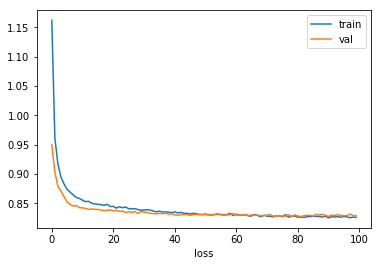

In [11]:
plt.plot(np.arange(nEpochs),history.history['loss'],label='train')
plt.plot(np.arange(nEpochs),history.history['val_loss'],label='val')
plt.xlabel('loss')
plt.legend()
plt.show()

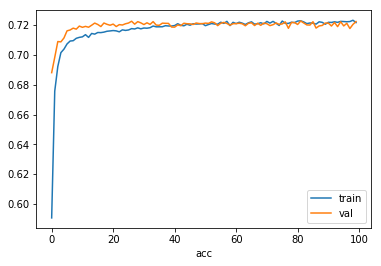

In [12]:
plt.plot(np.arange(nEpochs),history.history['acc'],label='train')
plt.plot(np.arange(nEpochs),history.history['val_acc'],label='val')
plt.xlabel('acc')
plt.legend()
plt.show()

- The individual loss doesn't get as low as when I trained on all of the jets with a varying number of tracks 
- The accuracy also doesn't get as high

*However*, my final metric is really just supposed to be whether I'm doing as well by comparing on the test set with the lower multiplicity of jets... so I need to **make a roc curve**!


- Could also try **dropout**


In [44]:
# Evaluate the performance with the ROC curves!
predictions = model.predict(X_te, batch_size=256, verbose=0)

# The rel fractions of the c and l-jet bkgs for this ttbar sample
fc = 0.07

# To make sure you're not discarding the b-values with high
# discriminant values that you're good at classifying, use the
# max from the distribution
disc = np.log(np.divide(predictions[:,2], fc*predictions[:,1] + (1 - fc) * predictions[:,0]))

discMax = np.max(disc)
discMin = np.min(disc)

myRange=(discMin,discMax)
nBins = 200

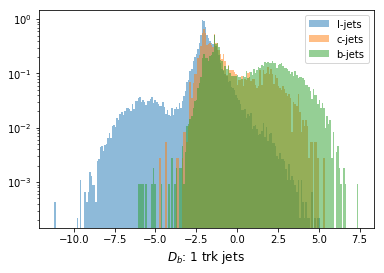

In [45]:
ntrk_leffs = []
ntrk_ceffs = []
ntrk_beffs = []
ntrk_labels = []

for yi, flav in zip([0,1,2],['l','c','b']):

    my_ix = (y_te == yi)

    
    n,_,_ = plt.hist(disc[my_ix],
                     bins=nBins,range=myRange, 
                     label="{}-jets".format(flav),
                     alpha = 0.5, density=True, log=True) 


    # Calculate the eff
    eff = calculateEff(n)

    if yi == 0:
        ntrk_leffs.append(eff)
    elif yi == 1:
        ntrk_ceffs.append(eff)
    elif yi == 2:
        ntrk_beffs.append(eff)

plt.legend()
plt.xlabel('$D_b$: 1 trk jets', fontsize=12)
#plt.title(label)
plt.show()

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


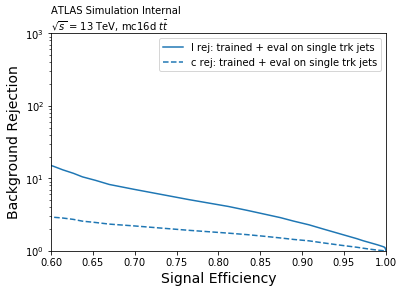

In [46]:
btagROC(ntrk_beffs, ntrk_leffs, ntrk_ceffs, 
        ['trained + eval on single trk jets'], colors=['C0'])#,
#         ymax=1e4,tag='PU_vs_GEANT',subDir='PU_studies')

Ok, so it's not clear here whether or not there are any gains from training this dedicated network....

Need to compare with the model trained on all of the tracks, evaluated on 1 trk jets!

In [47]:
doEmbedding=False
load_model=True
modelDir = "../models/mc16d/"

embedTag = 'gradeEmbed' if doEmbedding else 'noEmbed'
modelName = "LSTM_50units_10dense_{}_{}".format(dataTag,embedTag)

# Open the model
m = myLSTM(modelName=modelName, modelDir=modelDir, 
           loadModel=load_model, doEmbedding=doEmbedding)

Initialize method from myModel()
Loading previously trained LSTM


I also need to reload in the test set, but keeping the structure of the multi-length sequences

In [48]:
f = h5py.File("{}/data_{}.hdf5".format(dataFile,dataTag),"r")

X_te  = f['X_test'][:]
y_te  = f['y_test'][:]
ix_te = f['ix_test'][:]

f.close()


# test set
oneTrk_te = (jet_df.ip3d_ntrk == 1).values[ix_te]

X_te  = X_te[oneTrk_te]
y_te  = y_te[oneTrk_te]
ix_te = ix_te[oneTrk_te]

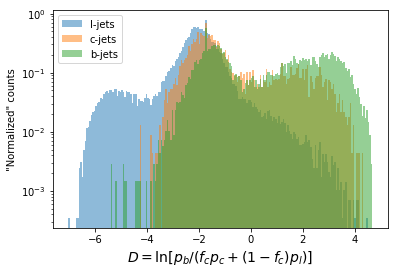

In [49]:
l_eff, c_eff, b_eff = sigBkgEff(m, X_te, y_te, ix_te)
    
ntrk_leffs.append(l_eff)
ntrk_ceffs.append(c_eff)
ntrk_beffs.append(b_eff)

In [50]:
labels = ['trained + eval on single trk jets','train on all, eval on single trk jets']

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


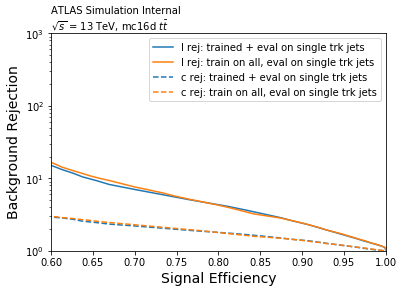

In [51]:
btagROC(ntrk_beffs, ntrk_leffs, ntrk_ceffs, labels, colors=['C0','C1'],
        tag='singleTrk',subDir='ip3d')

**Conclusion:**
- Since the dedicated training on single track jets didn't help, I think the issue is more of how we need to define the loss function to encourage an optimal training rather than a pure optimization issue.

**Lastly:**
- Compare with MV2C10 to see why we're getting better performance from including the other low-level algorithms!

In [52]:
jet_df.columns

Index(['LabDr_HadF', 'pt_orig', 'eta_orig', 'phi_orig', 'm', 'ip3d_llr',
       'ip3d_pb', 'ip3d_pc', 'ip3d_pu', 'ip3d_ntrk', 'mv2c10', 'aliveAfterOR',
       'llr', 'JVT', 'pt', 'eta', 'rnnip_pu', 'rnnip_pc', 'rnnip_pb',
       'rnnip_ptau', 'bH_Lxy'],
      dtype='object')

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


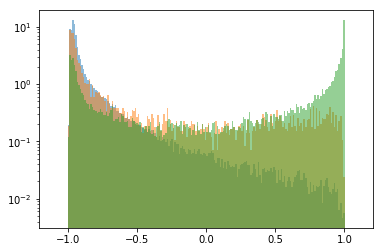

In [53]:
nBins = 200
myRange = (-1.1,1.1)

for pdg, flav in zip([0,4,5],['l','c','b']):
    
    mask = (jet_df.ip3d_ntrk == 1) & (jet_df.LabDr_HadF == pdg)
    
    n,_,_ = plt.hist(jet_df.mv2c10[mask],
                     bins=nBins,range=myRange, 
                     label="{}-jets".format(flav),
                     alpha = 0.5,
                     normed=True, log=True) 
    
    # Calculate the eff
    eff = calculateEff(n)
    
    if pdg == 0:
        ntrk_leffs.append(eff)
    elif pdg == 4:
        ntrk_ceffs.append(eff)
    elif pdg == 5:
        ntrk_beffs.append(eff)

In [54]:
labels = labels + ['mv2c10 eval on single trk jets']

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


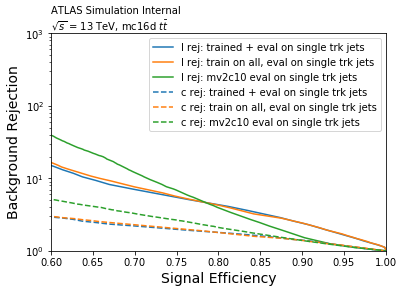

In [55]:
btagROC(ntrk_beffs, ntrk_leffs, ntrk_ceffs, labels, colors=['C0','C1','C2'],
        tag='singleTrk_mv2c10',subDir='ip3d')